In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import Normalizer
from sklearn import datasets
from sklearn.preprocessing import normalize
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import matplotlib.pyplot as plt
import statistics
from mlxtend.plotting import plot_decision_regions

In [ ]:
!pip3 install uci-dataset
from sklearn import datasets
import uci_dataset as dataset
!git clone https://github.com/tanmay-pro/sampleData.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'sampleData' already exists and is not an empty directory.


In [ ]:
def getValidk(trainX):
  loo = LeaveOneOut()
  loo.get_n_splits(trainX)
  validK = []
  for train_index, test_index in loo.split(trainX):
    trainData, testData = trainX[train_index], trainX[test_index]
    trainLabel, testLabel = trainY[train_index], trainY[test_index]
    validSampleK = []
    for k in range(2, 10):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(trainData, trainLabel)
        predicted = model.predict(testData)
        if predicted == testLabel:   
            validSampleK.append(k)
    validK.append(validSampleK)
  validK = np.array(validK, dtype=object)
  return validK

def getPreTrainedModels(trainX, trainY):
  trainedModels = []
  for i in range(2, 10):
    model = KNeighborsClassifier(n_neighbors=i)
    model.fit(trainX, trainY)
    trainedModels.append(model)
  return trainedModels    

def getPrediction(validK, trainedModels, M, trainX, testX, trainY):
  finalPredictions = []
  predictedKFrequency = [0]*10
  for i in range(0, len(testX)):
    distances = []
    for j in range(0, len(trainX)):
        distances.append(np.linalg.norm(testX[i] - trainX[j]))
    distances = np.array(distances)
    indices = np.argsort(distances)
    nebrIndices = indices[0:M]
    nebrLabels = trainY[nebrIndices]

    kCorrectClassified = np.zeros(10)
    for ind in nebrIndices:
        kcurrArray = validK[ind]
        for z in range(len(kcurrArray)):
            k = kcurrArray[z]
            kCorrectClassified[k] += 1
    kbest = np.argmax(kCorrectClassified)
    predictedKFrequency[kbest] += 1
    predictedClass = trainedModels[kbest - 2].predict(testX[i].reshape(1, -1))
    finalPredictions.append(predictedClass)
  return finalPredictions, predictedKFrequency

def localUnrestrictedKNN(trainX, testX, trainY, testY, M):
  validK = getValidk(trainX)
  trainedModels = getPreTrainedModels(trainX, trainY)
  predicted, predictedKFrequency = getPrediction(validK, trainedModels, M, trainX, testX, trainY)
  return predicted, predictedKFrequency, metrics.accuracy_score(testY, predicted)

In [ ]:
def prunedKNN(trainX, testX, trainY, testY, M):
  validK = getValidk(trainX)
  finalK = []
  for lst in validK:
    finalK = finalK + lst
  freq = np.bincount(np.array(finalK))

  bestL = 0
  bestScore = -1
  accValuesL = []
  for L in range(2, np.max(freq)):
    array_list = []
    for m in range(len(validK)):
      array_list.append(np.array(validK[m]))

    validK = array_list
    arr = np.array(validK, dtype=object)
    freq_to_prune = []
    
    for i in range(len(freq)):
      if(freq[i] < L):
        freq_to_prune.append(i)

    for i in range(arr.shape[0]):
      for j in freq_to_prune:
        if j in arr[i] and arr[i].shape[0] != 1:
          arr[i] = np.delete(arr[i], np.where(arr[i] == j))

    validK = []
    for i in range(arr.shape[0]):
      validK.append(arr[i])
    trainedModels = getPreTrainedModels(trainX, trainY)
    predicted, predictedKFrequency = getPrediction(validK, trainedModels, M, trainX, testX, trainY)
   # print(testY.shape, predicted.shape)
    score = metrics.accuracy_score(testY, predicted)
    if(score > bestScore):
      bestScore = score
      bestL = L
    # print("Current Accuracy: ", score, " for:", L)
    accValuesL.append(score)
  print("Best Accuracy: ", bestScore, " for:", bestL)
  plt.plot(accValuesL)
  plt.xlabel("Pruning Threshold")
  plt.ylabel("Accuracy")
  plt.grid()
  plt.show()
  return predicted, predictedKFrequency, bestScore

In [ ]:
seedsFile = '/content/sampleData/modifiedDatasets/seeds.csv'
df = pd.read_csv(seedsFile)
data = np.array(df)
Y = data[:,data.shape[1]-1]
# Y = np.reshape(Y, (len(Y),1))
X = np.delete(data, data.shape[1]-1, 1)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)


bestM = 0
bestScore = -1
for m in range(2,20):
  predicted, predictedKFrequency, accuracyScore  = localUnrestrictedKNN(normalized_x_train, normalized_x_test, trainY, testY, m)
  if(accuracyScore > bestScore):
    bestScore = accuracyScore
    bestM = m
  # print("Current Accuracy: ", accuracyScore, " for m =", m)
print("Best Accuracy: ", bestScore, " for m =", bestM)

Best Accuracy:  0.7477477477477478  for m = 8


Best Accuracy:  0.7657657657657657  for: 0


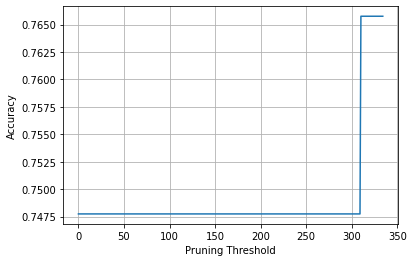

Accuracy Score =  0.7657657657657657
Chosen m =  8


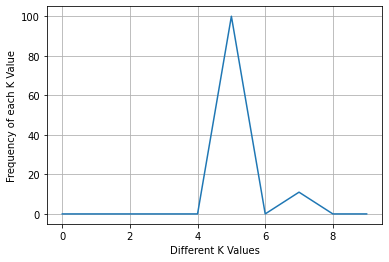

In [ ]:
predicted, predictedKFrequency, accuracyScore = prunedKNN(normalized_x_train, normalized_x_test, trainY, testY, bestM)
print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
print("Chosen m = ", bestM)
plt.plot(predictedKFrequency)
plt.xlabel("Different K Values")
plt.ylabel("Frequency of each K Value")
plt.grid()
plt.show()

In [ ]:
transfusionFile = '/content/sampleData/modifiedDatasets/transfusion.csv'
df = pd.read_csv(transfusionFile)
data = np.array(df)
Y = data[:,data.shape[1]-1]
# Y = np.reshape(Y, (len(Y),1))
X = np.delete(data, data.shape[1]-1, 1)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)


bestM = 0
bestScore = -1
for m in range(2,10):
  predicted, predictedKFrequency, accuracyScore  = localUnrestrictedKNN(normalized_x_train, normalized_x_test, trainY, testY, m)
  if(accuracyScore > bestScore):
    bestScore = accuracyScore
    bestM = m
  print("Current Accuracy: ", accuracyScore, " for m =", m)

Current Accuracy:  0.4625  for m = 2
Current Accuracy:  0.4875  for m = 3
Current Accuracy:  0.4625  for m = 4
Current Accuracy:  0.5  for m = 5
Current Accuracy:  0.5  for m = 6
Current Accuracy:  0.5125  for m = 7
Current Accuracy:  0.5125  for m = 8
Current Accuracy:  0.5125  for m = 9


Best Accuracy:  0.5625  for: 0


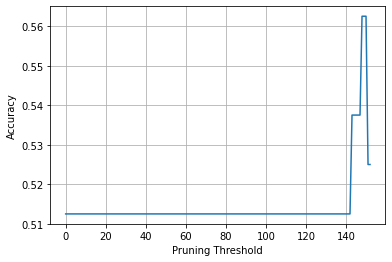

Accuracy Score =  0.525
Chosen m =  7


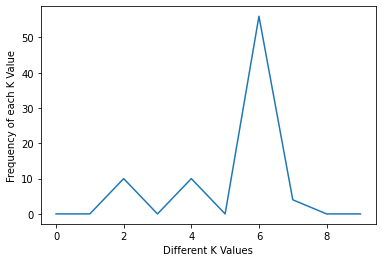

In [ ]:
predicted, predictedKFrequency, accuracyScore = prunedKNN(normalized_x_train, normalized_x_test, trainY, testY, bestM)
print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
print("Chosen m = ", bestM)
plt.plot(predictedKFrequency)
plt.xlabel("Different K Values")
plt.ylabel("Frequency of each K Value")
plt.show()

In [ ]:
soyFile = '/content/sampleData/modifiedDatasets/soybeans.csv'
df = pd.read_csv(soyFile)
data = np.array(df)
Y = data[:,data.shape[1]-1]
# Y = np.reshape(Y, (len(Y),1))
X = np.delete(data, data.shape[1]-1, 1)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)

bestM = 0
bestScore = -1
for m in range(2,10):
  predicted, predictedKFrequency, accuracyScore  = localUnrestrictedKNN(normalized_x_train, normalized_x_test, trainY, testY, m)
  if(accuracyScore > bestScore):
    bestScore = accuracyScore
    bestM = m
  print("Current Accuracy: ", accuracyScore, " for m =", m)



Current Accuracy:  0.5882352941176471  for m = 2
Current Accuracy:  0.6029411764705882  for m = 3
Current Accuracy:  0.5882352941176471  for m = 4
Current Accuracy:  0.6176470588235294  for m = 5
Current Accuracy:  0.5882352941176471  for m = 6
Current Accuracy:  0.5882352941176471  for m = 7
Current Accuracy:  0.5882352941176471  for m = 8
Current Accuracy:  0.5882352941176471  for m = 9


Best Accuracy:  0.6176470588235294  for: 0


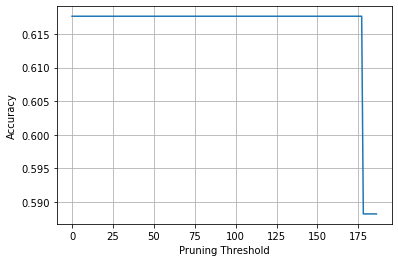

Accuracy Score =  0.5882352941176471
Chosen m =  5


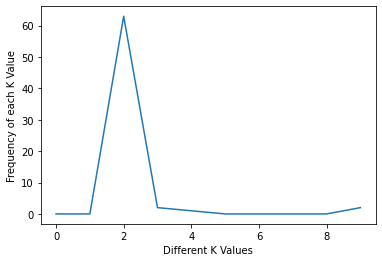

In [ ]:
predicted, predictedKFrequency, accuracyScore = prunedKNN(normalized_x_train, normalized_x_test, trainY, testY, bestM)
print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
print("Chosen m = ", bestM)
plt.plot(predictedKFrequency)
plt.xlabel("Different K Values")
plt.ylabel("Frequency of each K Value")
plt.show()

In [ ]:
immunoFile = '/content/sampleData/modifiedDatasets/Immuno.csv'
df = pd.read_csv(immunoFile)
data = np.array(df)
Y = data[:,data.shape[1]-1]
# Y = np.reshape(Y, (len(Y),1))
X = np.delete(data, data.shape[1]-1, 1)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.2, random_state=42)
normalized_x_train = normalize(trainX)
normalized_x_test = normalize(testX)


bestM = 0
bestScore = -1
for m in range(2,5):
  predicted, predictedKFrequency, accuracyScore  = localUnrestrictedKNN(normalized_x_train, normalized_x_test, trainY, testY, m)
  if(accuracyScore > bestScore):
    bestScore = accuracyScore
    bestM = m
  print("Current Accuracy: ", accuracyScore, " for m =", m)

Current Accuracy:  0.8219409282700422  for m = 2
Current Accuracy:  0.8210970464135021  for m = 3


In [ ]:
predicted, predictedKFrequency, accuracyScore = prunedKNN(normalized_x_train, normalized_x_test, trainY, testY, bestM)
print("Accuracy Score = ", metrics.accuracy_score(testY, predicted))
print("Chosen m = ", bestM)
plt.plot(predictedKFrequency)
plt.xlabel("Different K Values")
plt.ylabel("Frequency of each K Value")
plt.show()